In [5]:
# import sys
from collections import Mapping
import subprocess
from pathlib import Path
from easydict import EasyDict as edict
import ruamel.yaml as yaml


# sys.path.append('../studiogan')

ROOT_DIR = Path('..')
CONFIGS_DIR = Path(ROOT_DIR, "configs")


class DotConfig(Mapping):
    """
    Simple wrapper for config
    allowing access with dot notation
    """

    def __init__(self, yaml):
        self._dict = yaml

    def __getattr__(self, key):
        if key in self.__dict__:
            return super().__getattr__(key)
        if key in self._dict:
            value = self._dict[key]
            if isinstance(value, dict):
                return DotConfig(value)
            return value
        else:
            return None

    def items(self):
        return [(k, DotConfig(v)) for k, v in self._dict.items()]

    def keys(self):
        return self._dict.keys()

    def __len__(self):
        return len(self._dict)

    def __iter__(self):
        return self._dict.__iter__()

    def __getitem__(self, key):
        return self._dict[key]

    @property
    def dict(self):
        return self._dict

    def __contains__(self, key):
        return key in self._dict

    def __setitem__(self, key, value):
        self._dict[key] = value

In [6]:
from typing import Optional, Tuple

import torch
from torch import nn
from torchvision import transforms


class ModelRegistry:
    registry = {}

    @classmethod
    def register(cls, name: Optional[str] = None) -> nn.Module:
        def inner_wrapper(wrapped_class: nn.Module) -> nn.Module:
            if name is None:
                name_ = wrapped_class.__name__
            else:
                name_ = name
            cls.registry[name_] = wrapped_class
            return wrapped_class

        return inner_wrapper

    @classmethod
    def create(cls, name: str, **kwargs) -> nn.Module:
        model = cls.registry[name]
        model = model(**kwargs)
        return model


class NormalizeInverse(transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-10)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())


class BaseDiscriminator(nn.Module):
    def __init__(
        self,
        mean: Tuple[float, float, float],
        std: Tuple[float, float, float],
        output_layer: str,
    ):
        super().__init__()
        self.transform = transforms.Normalize(mean, std)
        if output_layer == "sigmoid":
            self.output_layer = nn.Sigmoid()
        else:
            self.output_layer = nn.Identity()

    def get_label(self) -> torch.LongTensor:
        return self.label.data.long()


class BaseGenerator(nn.Module):
    def __init__(
        self, mean: Tuple[float, float, float], std: Tuple[float, float, float]
    ):
        super().__init__()
        self.inverse_transform = transforms.Compose(
            [
                NormalizeInverse(mean, std),
                transforms.Lambda(lambda x: torch.clip(x, 0, 1)),
            ]
        )

    def sample_label(self, *args, **kwargs):
        return None

    def get_label(self) -> torch.LongTensor:
        return self.label.data.long()


In [7]:
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.utils.spectral_norm import spectral_norm

def _upsample(x):
    h, w = x.shape[2:]
    return F.interpolate(x, size=(h * 2, w * 2), mode="nearest")


def upsample_conv(x, conv):
    return conv(_upsample(x))


@ModelRegistry.register()
class SN_DCGAN_Generator(BaseGenerator):
    def __init__(
        self,
        n_hidden=128,
        bw=4,
        ch=512,
        nz=128,
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5),
    ):
        super().__init__(mean, std)
        self.z_dim = nz
        self.ch = ch
        self.bw = bw
        self.relu = nn.ReLU(True)
        self.tanh = nn.Tanh()
        self.l0 = nn.Linear(n_hidden, bw * bw * ch)
        self.dc1 = nn.ConvTranspose2d(ch, ch // 2, 4, 2, 1)
        self.dc2 = nn.ConvTranspose2d(ch // 2, ch // 4, 4, 2, 1)
        self.dc3 = nn.ConvTranspose2d(ch // 4, ch // 8, 4, 2, 1)
        self.dc4 = nn.ConvTranspose2d(ch // 8, 3, 3, 1, 1)
        self.bn0 = nn.BatchNorm2d(bw * bw * ch, eps=2e-5, momentum=0.1)
        self.bn1 = nn.BatchNorm2d(ch // 2, eps=2e-5, momentum=0.1)
        self.bn2 = nn.BatchNorm2d(ch // 4, eps=2e-5, momentum=0.1)
        self.bn3 = nn.BatchNorm2d(ch // 8, eps=2e-5, momentum=0.1)

    def forward(self, z, **kwargs):
        h = self.l0(z)
        h = h.view(-1, self.ch * self.bw * self.bw, 1, 1)
        h = self.relu(self.bn0(h))
        h = h.view(-1, self.ch, self.bw, self.bw)
        h = self.relu(self.bn1(self.dc1(h)))
        h = self.relu(self.bn2(self.dc2(h)))
        h = self.relu(self.bn3(self.dc3(h)))
        o = self.tanh(self.dc4(h))
        return o


@ModelRegistry.register()
class SN_DCGAN_Discriminator(BaseDiscriminator):
    def __init__(
        self,
        bw=4,
        ch=512,
        output_dim=1,
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5),
        output_layer="identity",
    ):
        super().__init__(mean, std, output_layer)
        c0_0 = nn.Conv2d(3, ch // 8, 3, 1, 1)
        self.c0_0 = spectral_norm(c0_0)

        c0_1 = nn.Conv2d(ch // 8, ch // 4, 4, 2, 1)
        self.c0_1 = spectral_norm(c0_1)

        c1_0 = nn.Conv2d(ch // 4, ch // 4, 3, 1, 1)
        self.c1_0 = spectral_norm(c1_0)

        c1_1 = nn.Conv2d(ch // 4, ch // 2, 4, 2, 1)
        self.c1_1 = spectral_norm(c1_1)

        c2_0 = nn.Conv2d(ch // 2, ch // 2, 3, 1, 1)
        self.c2_0 = spectral_norm(c2_0)

        c2_1 = nn.Conv2d(ch // 2, ch // 1, 4, 2, 1)
        self.c2_1 = spectral_norm(c2_1)

        c3_0 = nn.Conv2d(ch // 1, ch // 1, 3, 1, 1)
        self.c3_0 = spectral_norm(c3_0)

        l4 = nn.Linear(bw * bw * ch, output_dim)
        self.l4 = spectral_norm(l4)

        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    @property
    def penult_layer(self):
        return self.c3_0

    def forward(self, x):
        h = self.lrelu(self.c0_0(x))
        h = self.lrelu(self.c0_1(h))
        h = self.lrelu(self.c1_0(h))
        h = self.lrelu(self.c1_1(h))
        h = self.lrelu(self.c2_0(h))
        h = self.lrelu(self.c2_1(h))
        h = self.lrelu(self.c3_0(h))
        h = h.view(x.size(0), -1)
        return self.l4(h)


In [8]:
class GANWrapper:
    def __init__(self, config: DotConfig, device: torch.device, load_weights=True):
        self.config = config
        self.device = device

        self.gen = ModelRegistry.create(
            config.generator.name, **config.generator.params
        ).to(device)
        self.dis = ModelRegistry.create(
            config.discriminator.name, **config.discriminator.params
        ).to(device)

        if load_weights:
            self.load_weights()

        if config.dp:
            self.dis.transform = self.dis.module.transform
            self.dis.output_layer = self.dis.module.output_layer
            self.gen.inverse_transform = self.gen.module.inverse_transform
            self.gen.z_dim = self.gen.module.z_dim
            self.gen.sample_label = self.gen.module.sample_label

        self.eval()
        self.define_prior()
        self.label = None

    def load_weights(self):
        gen_path = Path(ROOT_DIR, self.config.generator.ckpt_path)
        state_dict = torch.load(
            gen_path, map_location=self.device
        )
        self.gen.load_state_dict(state_dict, strict=True)

        dis_path = Path(ROOT_DIR, self.config.discriminator.ckpt_path)
        state_dict = torch.load(
            dis_path,
            map_location=self.device,
        )
        self.dis.load_state_dict(state_dict, strict=True)

    def eval(self):
        for param in self.gen.parameters():
            param.requires_grad = False
        for param in self.dis.parameters():
            param.requires_grad = False
        self.gen.eval()
        self.dis.eval()

    def get_latent_code_dim(self):
        return self.gen.z_dim

    def define_prior(self):
        if self.config.prior == "normal":
            prior = torch.distributions.multivariate_normal.MultivariateNormal(
                torch.zeros(self.gen.z_dim).to(self.device),
                torch.eye(self.gen.z_dim).to(self.device),
            )
            prior.project = lambda z: z
        elif self.config.prior == "uniform":
            prior = torch.distributions.uniform.Uniform(
                -torch.ones(self.gen.z_dim).to(self.device),
                torch.ones(self.gen.z_dim).to(self.device),
            )
            prior.project = lambda z: torch.clip(z, -1 + 1e-9, 1 - 1e-9)
            prior.log_prob = lambda z: torch.zeros(z.shape[0], device=z.device)
        else:
            raise KeyError
        self.gen.prior = prior

    @property
    def transform(self):
        return self.dis.transform

    @property
    def inverse_transform(self):
        return self.gen.inverse_transform

    @property
    def prior(self):
        return self.gen.prior

    def set_label(self, label):
        if self.config.dp:
            self.gen.label = label if self.gen.cond else None
            self.dis.label = label if self.dis.cond else None
            self.label = label if self.dis.cond else None
        else:
            self.gen.label = label
            self.dis.label = label
            self.label = label

In [31]:
args = edict()

configs = ['configs/gan_sampling_cifar.yml', 'configs/gan_configs/sngan-ns.yml']
configs = [Path(ROOT_DIR, x).as_posix() for x in configs]
args.configs = configs

params = yaml.round_trip_load(Path(args.configs[0]).open("r"))

proc = subprocess.Popen("/bin/bash", stdin=subprocess.PIPE, stdout=subprocess.PIPE)
out, err = proc.communicate(
    (
        " ".join(
            [
                "echo",
                '"' + str(yaml.round_trip_dump(params)) + '"',
                "|",
                "cat - ",
                *args.configs[1:],
            ]
        )
    ).encode("utf-8")
)
config = yaml.round_trip_load(out.decode("utf-8"))
config = DotConfig(config)

In [32]:
device = torch.device(0)
gan = GANWrapper(config.gan_config, device)

In [33]:
from typing import Callable, List, Optional, Union
import torch
import numpy as np
# from torch.distributions import Distribution as torchDist


class DiscriminatorTarget:
    def __init__(
        self,
        gan,
    ):
        self.gan = gan
        self.proposal = gan.prior

    @staticmethod
    def latent_target(
        z: torch.FloatTensor,
        gan,
        proposal,
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor]:
        dgz = gan.dis(gan.gen(z)).squeeze()
        logp_z = proposal.log_prob(z)
        if dgz.shape != logp_z.shape:
            raise Exception
        log_prob = (logp_z + dgz) / 1.0

        return (log_prob, logp_z, dgz)

    def __call__(self, z: torch.FloatTensor, **kwargs) -> torch.FloatTensor:
        logp = self.latent_target(z, self.gan, self.proposal)[0]
        return logp

    def project(self, z):
        return self.proposal.project(z)


def grad_log_prob(
    point: torch.FloatTensor,
    log_dens,
    # x: Optional[Any] = None,
) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
    point = point.detach().requires_grad_()
    log_prob = log_dens(point)
    grad = torch.autograd.grad(log_prob.sum(), point)[0]
    return log_prob, grad


In [47]:
def grad_descent(
    z: torch.FloatTensor,
    target,
    proposal,
    step_size: float,
    n_steps: int = 1,
    project: Optional[Callable] = None,
) -> List[torch.FloatTensor]:
    zs = []

    for _ in range(n_steps):
        _, grad = grad_log_prob(z, target)
        z = z + step_size * grad
        z = project(z)
        z = z.data
        z.requires_grad_(True)
        zs.append(z.data)

    return zs


def ula(
    z: torch.FloatTensor,
    target,
    proposal,
    step_size: float,
    n_steps: int = 1,
    project: Optional[Callable] = None,
) -> List[torch.FloatTensor]:
    zs = []
    device = z.device

    for _ in range(n_steps):
        _, grad = grad_log_prob(z, target)
        noise = torch.randn_like(z, dtype=torch.float).to(device)
        noise_scale = (2.0 * step_size) ** 0.5
        z = z + step_size * grad + noise_scale * noise
        z = project(z)
        z = z.data
        z.requires_grad_(True)
        zs.append(z.data)

    return zs


def isir(
    z: torch.FloatTensor,
    target,
    proposal,
    step_size: float,
    N: int,
    n_steps: int = 1,
    project: Optional[Callable] = None,
) -> Tuple[List[torch.FloatTensor], float]: 
    zs = []
    batch_size, z_dim = z.shape[:2]
    acceptance = torch.zeros(batch_size)

    for _ in range(n_steps):
        X = proposal.sample((batch_size, N))
        X[np.arange(batch_size), [0] * batch_size, :] = z
        X_flat = X.view(-1, z_dim)
        log_weight = target(X_flat) - proposal.log_prob(X_flat)
        log_weight = log_weight.view(batch_size, N)
        max_logs = torch.max(log_weight, dim=1)[0][:, None]
        log_weight = log_weight - max_logs
        weight = torch.exp(log_weight)
        sum_weight = torch.sum(weight, dim=1)
        weight = weight / sum_weight[:, None]
        weight[weight != weight] = 0.0
        weight[weight.sum(1) == 0.0] = 1.0

        indices = torch.multinomial(weight, 1).squeeze()
        mask = (indices == 0).float()
        acceptance += mask.mean().item() / n_steps
        z = X[np.arange(batch_size), indices.tolist(), :]

        z = project(z)
        z = z.data
        z.requires_grad_(True)
        zs.append(z.data)

    return zs, acceptance


def heuristics_step_size(
    mean_acceptance: float,
    target_acceptance: float,
    step_size: float,
    factor: float = 1.05,
    tol: float = 0.03,
):
    if mean_acceptance - target_acceptance > tol:
        return step_size * factor
    if target_acceptance - mean_acceptance > tol:
        return step_size / factor
    return step_size


def mala(
    z: torch.FloatTensor,
    target,
    proposal,
    step_size: float,
    n_steps: int = 1,
    project: Optional[Callable] = None,
    adapt_stepsize: bool = False,
) -> Tuple[List[torch.FloatTensor], float]:
    zs = []
    batch_size, z_dim = z.shape[0], z.shape[1]

    white_noise = torch.distributions.MultivariateNormal(
        torch.zeros(z_dim).to(z.device),
        torch.eye(z_dim).to(z.device),
    )
    noise_scale = (2.0 * step_size) ** 0.5
    uniform = torch.distributions.Uniform(low=0.0, high=1.0)
    acceptance = torch.zeros(batch_size).to(z.device)

    for _ in range(n_steps):
        noise = noise_scale * white_noise.sample((batch_size,))
        log_prob, grad = grad_log_prob(z, target)
        new_z = z + step_size * grad + noise
        new_z = new_z.data
        new_z.requires_grad_(True)

        log_prob_new, grad_new = grad_log_prob(new_z, target)

        propose_vec_1 = z - new_z - step_size * grad_new
        propose_vec_2 = new_z - z - step_size * grad
        propose_part = white_noise.log_prob(propose_vec_1 / noise_scale)
        propose_part_new = white_noise.log_prob(propose_vec_2 / noise_scale)
        
        log_accept_prob = propose_part - propose_part_new + log_prob_new - log_prob

        generate_uniform_var = uniform.sample((batch_size,)).to(z.device)
        log_generate_uniform_var = torch.log(generate_uniform_var)
        mask = log_generate_uniform_var < log_accept_prob

        if adapt_stepsize:
            mean_acceptance = mask.float().mean()
            step_size = heuristics_step_size(
                mean_acceptance,
                target_acceptance=0.5,
                step_size=step_size,
            )
            noise_scale = (2.0 * step_size) ** 0.5
            #print(step_size)

        acceptance += mask
        with torch.no_grad():
            z[mask] = new_z[mask]
            z = project(z)
            z = z.data
            z.requires_grad_(True)
            zs.append(z.clone().detach())

    return zs, acceptance, step_size


def ex2mcmc(
    z: torch.FloatTensor,
    target,
    proposal,
    step_size: float,
    N: int,
    n_steps: int = 1,
    project: Optional[Callable] = None,
    adapt_stepsize: bool = False,
) -> Tuple[List[torch.FloatTensor], float]:
    zs = []
    for _ in range(n_steps):
        z = isir(z, target, proposal, step_size, N, 1, project)[0][-1]
        inter_zs, _, step_size = mala(z, target, proposal, step_size, 1, project, adapt_stepsize=adapt_stepsize)
        z = inter_zs[-1]
        z = z.data
        z.requires_grad_(True)
        zs.append(z.clone().detach())

    return zs, step_size


In [48]:
target = DiscriminatorTarget(gan)

z_0 = gan.prior.sample((config.batch_size,))

In [49]:
config.n_steps = 1000

In [53]:
zs = grad_descent(z_0, target, gan.prior, config.step_size, config.n_steps, gan.prior.project)
zs = zs[::config.every]
energy = [-target(z).mean().item() for z in zs]

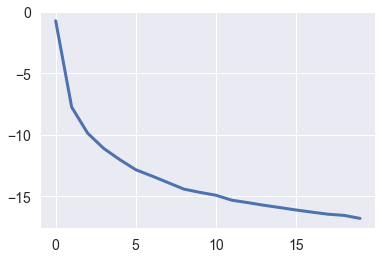

In [54]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme()

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("lines", linewidth=3)
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title


plt.plot(energy)